In [1]:
# Import relevant libraries
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
from matplotlib import colors
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning, PolicyIterationModified
import random
from timeit import default_timer as timer
from datetime import timedelta
import time
import copy
from hiive.mdptoolbox.example import forest
# Set the random seed
np.random.seed(42)

In [2]:
T, R = forest(S=256, r1 = 500, r2 = 5, p = 0.01)

In [48]:
colors = {
    0: 'g',
    1: 'k'
}

labels = {
    0: 'W',
    1: 'C',
}

def plot_forest(policy, title='Forest Management'):
    rows = 16
    cols = 16
    
    policy = np.array(list(policy)).reshape(rows,cols)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, xlim=(-.01, cols+0.01), ylim = (-.01, rows+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    
    for i in range(rows):
        for j in range(cols):
            y = rows - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i,j]])
            ax.add_patch(p)
            
            text = ax.text(x+0.5, y+0.5, labels[policy[i, j]],
                           horizontalalignment='center', size=25, verticalalignment='center', color='w')
    
    plt.axis('off')
    
def evaluate_policy(P, R, policy, test_count=100, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  np.random.choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / test_count

In [5]:
def trainPI_2(P, R, discount=0.9, epsilon =0.001):
    pi_df = pd.DataFrame(columns=['Discount','Epsilon', "Policy", "Iteration", 
                                  "Time", "Reward",
                                  "Value Function",
                                  #'Avg_Steps','Steps_StDev','Success_Rate'
                                 ])
    pi_run_full = pd.DataFrame()

    for gamma in discount:
        for eps in epsilon:
            pi = PolicyIterationModified(P, R, gamma=gamma, epsilon = eps, max_iter=int(30))
            pi_run = pi.run()
            pi_run_df = pd.DataFrame(pi_run)
            pi_run_df['Gamma'] = str(float(gamma))
            pi_run_df['Eps'] = str(float(eps))
            
            #print(pi_run_df)

            reward = max(pi_run_df['Reward'])
            #steps, steps_stddev, failures = get_score(env, pi.policy, None)
            info = [float(gamma),float(eps), pi.policy, pi.iter, pi.time, reward,
                    pi.V,
                    #steps,steps_stddev,
                    #Success is 100% - failure%
                    #100-failures
                   ]
            df_length = len(pi_df)
            pi_df.loc[df_length] = info

            pi_run_full = pd.concat([pi_run_full,pi_run_df])
            
    return pi_df, pi_run,pi,pi_run_full

In [6]:
%%time
discount= [0.5,0.75,0.9,0.99]
epsilon=[1e-3,1e-5,1e-7]

pi_df,pi_run,pi,pi_run_full = trainPI_2(T, R, discount= discount, epsilon=epsilon)
pi_df

Wall time: 2min 31s


,Discount,Epsilon,Policy,Iteration,Time,Reward,Value Function
0,0.50,1.000000e-03,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",10,0.042338,990.105566,"(0.6622073578567383, 1.3311036789253117, 1.331..."
1,0.50,1.000000e-05,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",10,0.040301,990.105566,"(0.6622073578567383, 1.3311036789253117, 1.331..."
2,0.50,1.000000e-07,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",10,0.038028,990.105566,"(0.6622073578567383, 1.3311036789253117, 1.331..."
3,0.75,1.000000e-03,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23,0.184127,1941.797217,"(1.7044476326956235, 2.2783357245195, 2.278335..."
4,0.75,1.000000e-05,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23,0.176409,1941.797217,"(1.7044476326956235, 2.2783357245195, 2.278335..."
5,0.75,1.000000e-07,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23,0.173464,1941.797217,"(1.7044476326956235, 2.2783357245195, 2.278335..."
6,0.90,1.000000e-03,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",60,1.207241,4587.545010,"(4.711792702185636, 5.240613431959124, 5.24061..."
7,0.90,1.000000e-05,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",60,1.190243,4587.545010,"(4.711792702185636, 5.240613431959124, 5.24061..."
8,0.90,1.000000e-07,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",60,1.201175,4587.545010,"(4.711792702185636, 5.240613431959124, 5.24061..."
9,0.99,1.000000e-03,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",255,49.152727,25273.437307,"(297.11135437699033, 300.142793560599, 303.235..."


In [16]:
pi_df_05_e3 = pi_run_full[(pi_run_full['Eps'].isin(['0.001'])) &(pi_run_full['Gamma'].isin(['0.5']))]
pi_df_05_e5 = pi_run_full[(pi_run_full['Eps'].isin(['1e-05'])) &(pi_run_full['Gamma'].isin(['0.5']))]
pi_df_05_e7 = pi_run_full[(pi_run_full['Eps'].isin(['1e-07'])) &(pi_run_full['Gamma'].isin(['0.5']))]

pi_df_075_e3 = pi_run_full[(pi_run_full['Eps'].isin(['0.001'])) &(pi_run_full['Gamma'].isin(['0.75']))]
pi_df_075_e5 = pi_run_full[(pi_run_full['Eps'].isin(['1e-05'])) &(pi_run_full['Gamma'].isin(['0.75']))]
pi_df_075_e7 = pi_run_full[(pi_run_full['Eps'].isin(['1e-07'])) &(pi_run_full['Gamma'].isin(['0.75']))]

pi_df_09_e3 = pi_run_full[(pi_run_full['Eps'].isin(['0.001'])) &(pi_run_full['Gamma'].isin(['0.9']))]
pi_df_09_e5 = pi_run_full[(pi_run_full['Eps'].isin(['1e-05'])) &(pi_run_full['Gamma'].isin(['0.9']))]
pi_df_09_e7 = pi_run_full[(pi_run_full['Eps'].isin(['1e-07'])) &(pi_run_full['Gamma'].isin(['0.9']))]

pi_df_099_e3 = pi_run_full[(pi_run_full['Eps'].isin(['0.001'])) &(pi_run_full['Gamma'].isin(['0.99']))]
pi_df_099_e5 = pi_run_full[(pi_run_full['Eps'].isin(['1e-05'])) &(pi_run_full['Gamma'].isin(['0.99']))]
pi_df_099_e7 = pi_run_full[(pi_run_full['Eps'].isin(['1e-07'])) &(pi_run_full['Gamma'].isin(['0.99']))]

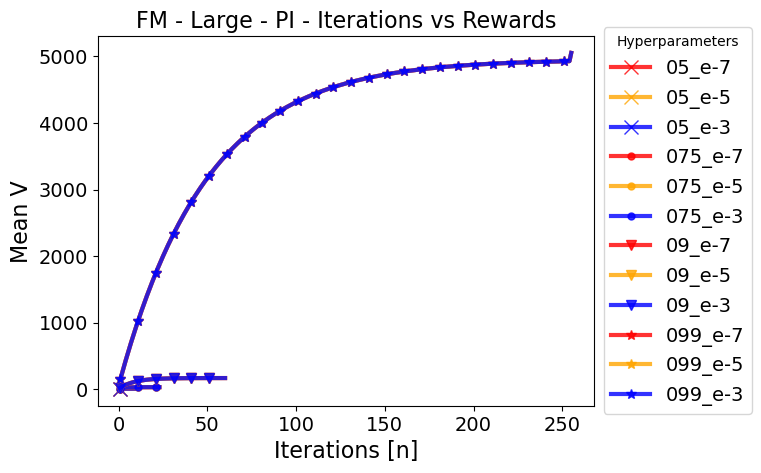

In [20]:
plt.plot(pi_df_05_e7['Iteration'],pi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7',markevery=10)
plt.plot(pi_df_05_e5['Iteration'],pi_df_05_e5['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='05_e-5',markevery=10)
plt.plot(pi_df_05_e3['Iteration'],pi_df_05_e3['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='05_e-3',markevery=10)

plt.plot(pi_df_075_e7['Iteration'],pi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='075_e-7',markevery=10)
plt.plot(pi_df_075_e5['Iteration'],pi_df_075_e5['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-5',markevery=10)
plt.plot(pi_df_075_e3['Iteration'],pi_df_075_e3['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='075_e-3',markevery=10)

plt.plot(pi_df_09_e7['Iteration'],pi_df_09_e7['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'red', label='09_e-7',markevery=10)
plt.plot(pi_df_09_e5['Iteration'],pi_df_09_e5['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'orange', label='09_e-5',markevery=10)
plt.plot(pi_df_09_e3['Iteration'],pi_df_09_e3['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'b', label='09_e-3',markevery=10)

plt.plot(pi_df_099_e7['Iteration'],pi_df_099_e7['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'red', label='099_e-7',markevery=10)
plt.plot(pi_df_099_e5['Iteration'],pi_df_099_e5['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'orange', label='099_e-5',markevery=10)
plt.plot(pi_df_099_e3['Iteration'],pi_df_099_e3['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'b', label='099_e-3',markevery=10)


plt.xlabel("Iterations [n]",fontsize = 16)
plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FM - Large - PI - Iterations vs Rewards', size =16)
plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
#plt.xscale('log')

Text(0.5, 1.0, 'FM - Large - PI - Iterations vs Error')

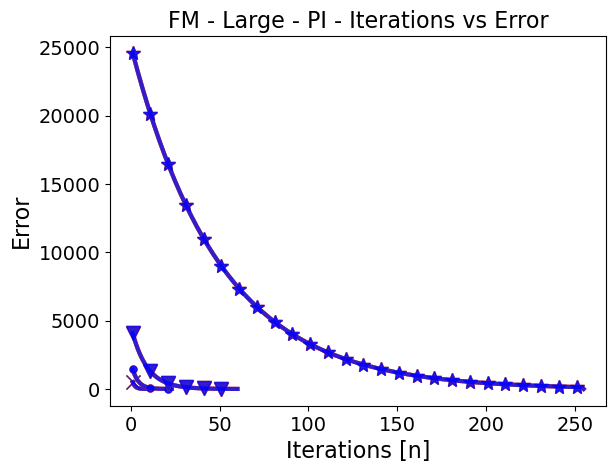

In [23]:
plt.plot(pi_df_05_e7['Iteration'],pi_df_05_e7['Error'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7',markevery=10)
plt.plot(pi_df_05_e5['Iteration'],pi_df_05_e5['Error'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='05_e-5',markevery=10)
plt.plot(pi_df_05_e3['Iteration'],pi_df_05_e3['Error'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='05_e-3',markevery=10)

plt.plot(pi_df_075_e7['Iteration'],pi_df_075_e7['Error'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='075_e-7',markevery=10)
plt.plot(pi_df_075_e5['Iteration'],pi_df_075_e5['Error'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-5',markevery=10)
plt.plot(pi_df_075_e3['Iteration'],pi_df_075_e3['Error'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='075_e-3',markevery=10)

plt.plot(pi_df_09_e7['Iteration'],pi_df_09_e7['Error'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='09_e-7',markevery=10)
plt.plot(pi_df_09_e5['Iteration'],pi_df_09_e5['Error'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='09_e-5',markevery=10)
plt.plot(pi_df_09_e3['Iteration'],pi_df_09_e3['Error'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='09_e-3',markevery=10)

plt.plot(pi_df_099_e7['Iteration'],pi_df_099_e7['Error'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='099_e-7',markevery=10)
plt.plot(pi_df_099_e5['Iteration'],pi_df_099_e5['Error'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='099_e-5',markevery=10)
plt.plot(pi_df_099_e3['Iteration'],pi_df_099_e3['Error'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='099_e-3',markevery=10)


plt.xlabel("Iterations [n]",fontsize = 16)
plt.ylabel("Error",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(-0.02,0.05)
plt.title('FM - Large - PI - Iterations vs Error', size =16)
#plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})

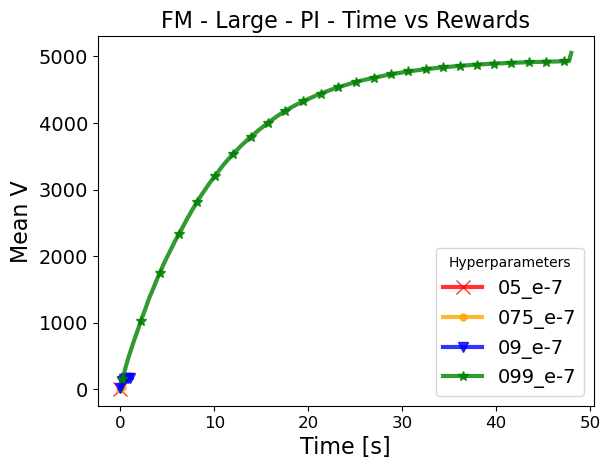

In [30]:
plt.plot(pi_df_05_e7['Time'],pi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7',markevery=10)
#plt.plot(pi_df_05_e5['Time'],pi_df_05_e5['Reward'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'firebrick', label='05_e-5')
#plt.plot(pi_df_05_e3['Time'],pi_df_05_e3['Reward'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'lightcoral', label='05_e-3')

plt.plot(pi_df_075_e7['Time'],pi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-7',markevery=10)
#plt.plot(pi_df_075_e5['Time'],pi_df_075_e5['Reward'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'bisque', label='075_e-5')
#plt.plot(pi_df_075_e3['Time'],pi_df_075_e3['Reward'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'peru', label='075_e-3')

plt.plot(pi_df_09_e7['Time'],pi_df_09_e7['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'blue', label='09_e-7',markevery=10)
#plt.plot(pi_df_09_e5['Time'],pi_df_09_e5['Reward'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'navy', label='09_e-5')
#plt.plot(pi_df_09_e3['Time'],pi_df_09_e3['Reward'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'cyan', label='09_e-3')

plt.plot(pi_df_099_e7['Time'],pi_df_099_e7['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'green', label='099_e-7',markevery=10)
#plt.plot(pi_df_099_e5['Time'],pi_df_099_e5['Reward'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'lightgreen', label='099_e-5')
#plt.plot(pi_df_099_e3['Time'],pi_df_099_e3['Reward'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'lawngreen', label='099_e-3')


plt.xlabel("Time [s]",fontsize = 16)

plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
plt.title('FM - Large - PI - Time vs Rewards', size =16)
plt.legend(title="Hyperparameters", loc="best",prop={'size': 14})
#plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 



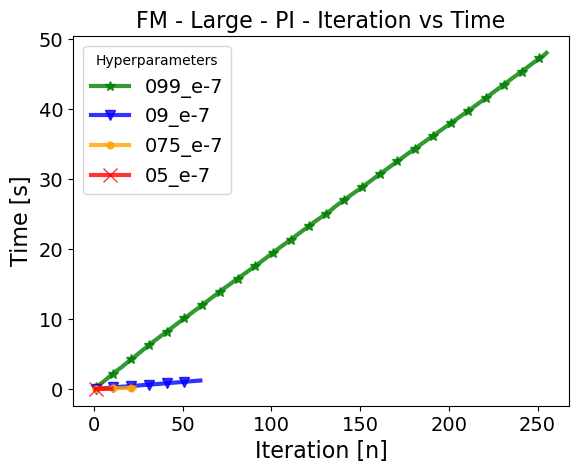

In [33]:
plt.plot(pi_df_099_e7['Iteration'],pi_df_099_e7['Time'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'green', label='099_e-7',markevery=10)
plt.plot(pi_df_09_e7['Iteration'],pi_df_09_e7['Time'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'blue', label='09_e-7',markevery=10)
plt.plot(pi_df_075_e7['Iteration'],pi_df_075_e7['Time'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-7',markevery=10)
plt.plot(pi_df_05_e7['Iteration'],pi_df_05_e7['Time'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7',markevery=10)

plt.xlabel("Iteration [n]",fontsize = 16)
plt.ylabel("Time [s]",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FM - Large - PI - Iteration vs Time', size =16)
plt.legend(title="Hyperparameters", loc="best",prop={'size': 14})

In [35]:
%%time
applied_df_full =pd.DataFrame()
for i in range(0,5):
    applied_df = pi_df.apply(lambda x: evaluate_policy(T,R, x["Policy"]), axis =1)
    applied_df = applied_df.to_frame()
    applied_df = applied_df.rename(columns = {0:'Score_'+str(i)})
    applied_df['Epsilon'] = pi_df['Epsilon']
    applied_df['Discount'] = pi_df['Discount']
    applied_df_full = pd.concat([applied_df_full,applied_df], axis =1)

Wall time: 36min 3s


In [36]:
applied_df_full = applied_df_full.loc[:,~applied_df_full.columns.duplicated()].copy()
applied_df_full

,Score_0,Epsilon,Discount,Score_1,Score_2,Score_3,Score_4
0,4701.756852,1.000000e-03,0.50,4743.402730,4682.769335,4760.424531,4865.657175
1,4970.389109,1.000000e-05,0.50,4738.595206,4664.376334,4920.123561,4945.866013
2,4735.154123,1.000000e-07,0.50,4870.869641,4857.934721,4801.644800,4833.970668
3,4704.281793,1.000000e-03,0.75,4863.370715,4816.798346,4609.248949,4760.340184
4,4867.877676,1.000000e-05,0.75,4739.317549,4843.613147,4828.236506,4698.352763
5,4887.447185,1.000000e-07,0.75,4790.797718,4896.186825,4672.425399,4755.997413
6,4742.022204,1.000000e-03,0.90,4636.047148,4615.838505,4919.167024,4811.816733
7,4621.607516,1.000000e-05,0.90,4842.995121,4773.259411,4803.377767,4771.390560
8,4825.944825,1.000000e-07,0.90,4752.529781,4713.727008,4736.002067,4837.733569
9,4630.850949,1.000000e-03,0.99,4524.182896,4606.565656,4540.615890,4535.642386


In [37]:
applied_df_full['Score_Mean'] = applied_df_full.loc[:, ["Score_0","Score_1","Score_2","Score_3","Score_4"]].mean(axis = 1)
applied_df_full['Score_Std'] = applied_df_full.loc[:, ["Score_0","Score_1","Score_2","Score_3","Score_4"]].std(axis = 1)

In [38]:
applied_df_full

,Score_0,Epsilon,Discount,Score_1,Score_2,Score_3,Score_4,Score_Mean,Score_Std
0,4701.756852,1.000000e-03,0.50,4743.402730,4682.769335,4760.424531,4865.657175,4750.802125,71.366875
1,4970.389109,1.000000e-05,0.50,4738.595206,4664.376334,4920.123561,4945.866013,4847.870045,137.336843
2,4735.154123,1.000000e-07,0.50,4870.869641,4857.934721,4801.644800,4833.970668,4819.914791,54.216333
3,4704.281793,1.000000e-03,0.75,4863.370715,4816.798346,4609.248949,4760.340184,4750.807997,99.145860
4,4867.877676,1.000000e-05,0.75,4739.317549,4843.613147,4828.236506,4698.352763,4795.479528,72.833943
5,4887.447185,1.000000e-07,0.75,4790.797718,4896.186825,4672.425399,4755.997413,4800.570908,93.799619
6,4742.022204,1.000000e-03,0.90,4636.047148,4615.838505,4919.167024,4811.816733,4744.978323,125.857964
7,4621.607516,1.000000e-05,0.90,4842.995121,4773.259411,4803.377767,4771.390560,4762.526075,83.958251
8,4825.944825,1.000000e-07,0.90,4752.529781,4713.727008,4736.002067,4837.733569,4773.187450,55.440460
9,4630.850949,1.000000e-03,0.99,4524.182896,4606.565656,4540.615890,4535.642386,4567.571555,47.836903


In [39]:
a1 = applied_df_full[applied_df_full['Epsilon']==1.e-07]
a2 = applied_df_full[applied_df_full['Epsilon']==1.e-05]
a3 = applied_df_full[applied_df_full['Epsilon']==1.e-03]

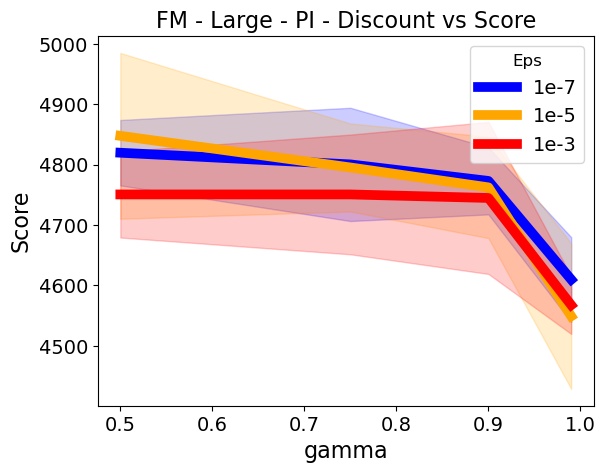

In [40]:
plt.plot(a1['Discount'],a1['Score_Mean'],linewidth =7,color="blue", label='1e-7')
plt.fill_between(a1['Discount'], a1['Score_Mean']+a1['Score_Std'],a1['Score_Mean']-a1['Score_Std'], alpha=0.2, color="blue")


plt.plot(a2['Discount'],a2['Score_Mean'],linewidth =7,color="orange", label='1e-5')
plt.fill_between(a2['Discount'], a2['Score_Mean']+a2['Score_Std'],a2['Score_Mean']-a2['Score_Std'], alpha=0.2, color="orange")

plt.plot(a3['Discount'],a3['Score_Mean'],linewidth =7,color="red", label='1e-3')
plt.fill_between(a3['Discount'], a3['Score_Mean']+a3['Score_Std'],a3['Score_Mean']-a3['Score_Std'], alpha=0.2, color="red")


plt.xlabel('gamma',fontsize = 16)
plt.ylabel('Score',fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(75,85)
plt.title('FM - Large - PI - Discount vs Score', fontsize=16)
# plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
plt.legend(title="Eps",title_fontsize=12, loc="best",prop={'size': 14})

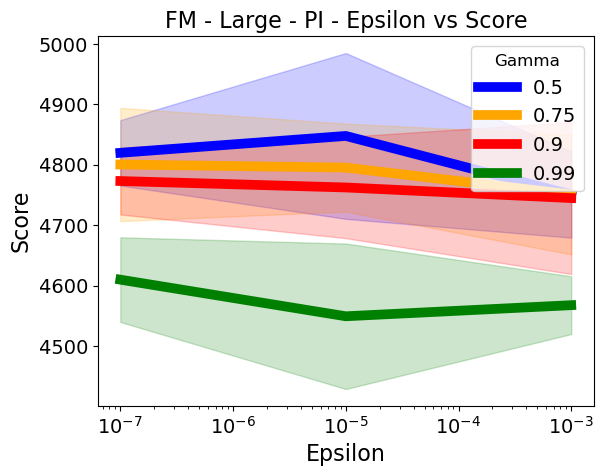

In [41]:
b1 = applied_df_full[applied_df_full['Discount']==0.5]
b2 = applied_df_full[applied_df_full['Discount']==0.75]
b3 = applied_df_full[applied_df_full['Discount']==0.9]
b4 = applied_df_full[applied_df_full['Discount']==0.99]


plt.plot(b1['Epsilon'],b1['Score_Mean'],linewidth =7,color="blue", label='0.5')
plt.fill_between(b1['Epsilon'], b1['Score_Mean']+b1['Score_Std'],b1['Score_Mean']-b1['Score_Std'], alpha=0.2, color="blue")


plt.plot(b2['Epsilon'],b2['Score_Mean'],linewidth =7,color="orange", label='0.75')
plt.fill_between(b2['Epsilon'], b2['Score_Mean']+b2['Score_Std'],b2['Score_Mean']-b2['Score_Std'], alpha=0.2, color="orange")

plt.plot(b3['Epsilon'],b3['Score_Mean'],linewidth =7,color="red", label='0.9')
plt.fill_between(b3['Epsilon'], b3['Score_Mean']+b3['Score_Std'],b3['Score_Mean']-b3['Score_Std'], alpha=0.2, color="red")

plt.plot(b4['Epsilon'],b4['Score_Mean'],linewidth =7,color="green", label='0.99')
plt.fill_between(b4['Epsilon'], b4['Score_Mean']+b4['Score_Std'],b4['Score_Mean']-b4['Score_Std'], alpha=0.2, color="green")


plt.xlabel('Epsilon',fontsize = 16)
plt.ylabel('Score',fontsize = 16)
plt.xscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(75,85)
plt.title('FM - Large - PI - Epsilon vs Score', fontsize=16)
plt.legend(title="Gamma",title_fontsize=12, loc="best",prop={'size': 14})

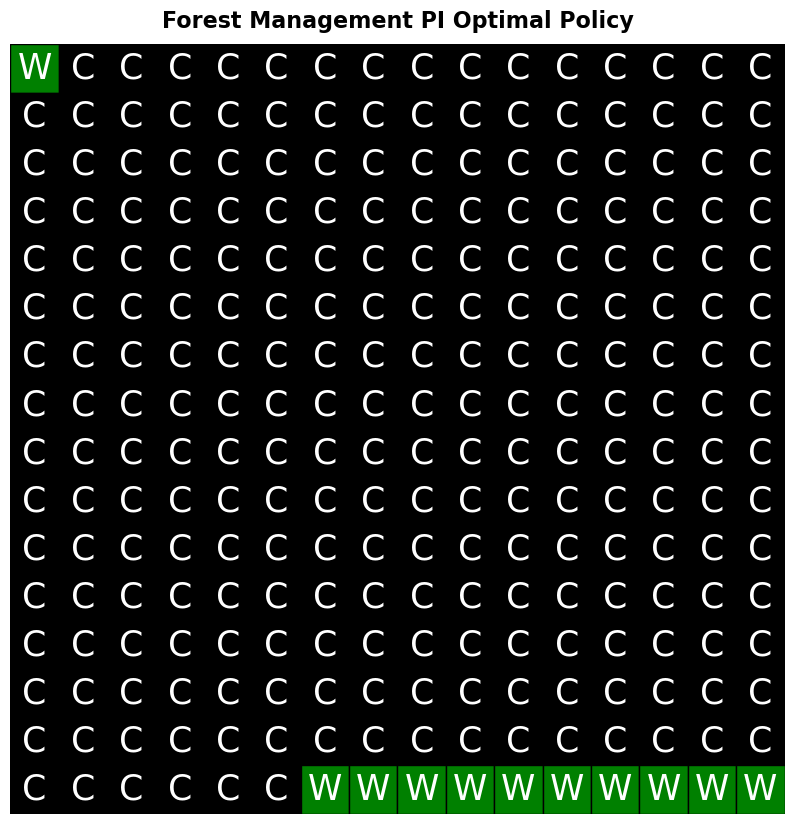

In [49]:
bestPolicy =  pi_df.loc[2]['Policy']

title='Forest Management PI Optimal Policy'
plot_forest(bestPolicy, title)